# Description

This notebook includes data cleaning, preprocessing, exploratory analaysis, and modeling for the dataset (headsets.csv).

## Load relevant packages and data

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import sklearn

from ast import literal_eval
from scipy.stats import skew

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report, confusion_matrix, accuracy_score

In [4]:
headsets_df = pd.read_csv('headsets.csv')
#print(headsets_df.head())
#print(headsets_df.dtypes)

## Data Cleaning/Preprocessing

In [5]:
print(headsets_df.isnull().sum())
headsets_df = headsets_df.dropna()
print(headsets_df.isnull().sum())

brand                   0
model                   0
form_factor             0
frequency_response    558
has_microphone          0
is_wireless             0
type                    0
color                   9
price                   0
dtype: int64
brand                 0
model                 0
form_factor           0
frequency_response    0
has_microphone        0
is_wireless           0
type                  0
color                 0
price                 0
dtype: int64


In [6]:
# ----- DATA CLEANING/PREPROCESSING -----

# Price Column - Extract numeric value, create new price column, drop old price column
print(type(headsets_df['price'].iloc[0]))

headsets_df['price_usd'] = headsets_df['price'].apply(
    lambda x: float(literal_eval(x)[1]) if isinstance(x, str) else None
)

#print(headsets_df['price_usd'].head())
#print(headsets_df['price_usd'].describe())

headsets_new = headsets_df.drop(columns=['price'])
#print(headsets_new.columns)
#print(headsets_new.dtypes)

<class 'str'>


<ipython-input-6-53c54f365b1d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  headsets_df['price_usd'] = headsets_df['price'].apply(


In [7]:
print((headsets_new['price_usd'] == 0).sum()) # total of 1673 zeros so we drop these rows

headsets_new = headsets_new[headsets_new['price_usd'] > 0].copy()
print(headsets_new['price_usd'].describe())

1247
count     603.000000
mean      127.403566
std       175.681742
min         4.990000
25%        34.990000
50%        79.000000
75%       159.485000
max      2018.270000
Name: price_usd, dtype: float64


In [8]:
# Converting boolean values to integers (0 and 1)
headsets_new['has_microphone'] = headsets_new['has_microphone'].astype(int)
headsets_new['is_wireless'] = headsets_new['is_wireless'].astype(int)

headsets_new['frequency_response'] = headsets_new['frequency_response'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
headsets_new['min_freq'] = headsets_new['frequency_response'].apply(lambda x: x['min'] if isinstance(x, dict) and 'min' in x else None)
headsets_new['max_freq'] = headsets_new['frequency_response'].apply(lambda x: x['max'] if isinstance(x, dict) and 'max' in x else None)

headsets_new = headsets_new.drop(columns=['frequency_response'])
print(headsets_new.head())

    brand                             model  form_factor  has_microphone  \
1   1MORE                       Quad Driver       In Ear               1   
2   1MORE        Triple Driver (Black/Gold)       In Ear               1   
3   1MORE            Triple Driver (Silver)       In Ear               1   
4   1MORE  Triple Driver Lightning (Silver)       In Ear               1   
10  ADATA                       EMIX H30 SE  Circumaural               1   

    is_wireless    type         color  price_usd  min_freq  max_freq  
1             0  Closed   Black / Red     124.23      20.0   40000.0  
2             0  Closed  Black / Gold      79.98      20.0   40000.0  
3             0  Closed        Silver      67.98      20.0   40000.0  
4             0  Closed        Silver      84.95      20.0   40000.0  
10            0  Closed   Black / Red      88.98      20.0   20000.0  


In [9]:
print(headsets_new.dtypes)

brand              object
model              object
form_factor        object
has_microphone      int64
is_wireless         int64
type               object
color              object
price_usd         float64
min_freq          float64
max_freq          float64
dtype: object


In [10]:
# Check unique values for form_factor, type, color
print(headsets_new['form_factor'].unique())
headsets_filtered = headsets_new[headsets_new['form_factor'].isin(['Circumaural', 'Supra-aural'])].copy()
print(headsets_filtered['form_factor'].unique())

['In Ear' 'Circumaural' 'Supra-aural' 'Earbud']
['Circumaural' 'Supra-aural']


In [11]:
print(headsets_filtered['type'].unique())
print(headsets_filtered['color'].unique(), "\n")

# Label encode 'form_factor' and 'type'
le_form = LabelEncoder()
le_type = LabelEncoder()

headsets_filtered['form_factor'] = le_form.fit_transform(headsets_filtered['form_factor'])
form_mapping = dict(zip(le_form.classes_, le_form.transform(le_form.classes_)))
print("Form Factor Encoding Mapping:", form_mapping)

headsets_filtered['type'] = le_type.fit_transform(headsets_filtered['type'])
type_mapping = dict(zip(le_type.classes_, le_type.transform(le_type.classes_)))
print("Type Encoding Mapping:", type_mapping)

['Closed' 'Semi-open' 'Open']
['Black / Red' 'Black' 'Black / Silver' 'Beige' 'White' 'Black / Blue'
 'Black / Orange' 'Black / Green' 'Silver / Black' 'White / Gray'
 'Black / Gold' 'Green / Black' 'Brown' 'White / Silver' 'Black / Brown'
 'Gray' 'Black / White' 'Silver' 'Black / Gray' 'Black / Yellow'
 'Black / Beige' 'Orange / White' 'Blue' 'Blue / Black' 'Gunmetal'
 'Green / White' 'Pink / Black' 'White / Blue' 'Black / Copper'
 'Red / Black' 'Red / White' 'Camo' 'White / Black' 'Brown / Black'
 'White / Brown' 'Red / Amber' 'Red' 'Green' 'White / Purple'
 'Blue / White' 'Multicolor'] 

Form Factor Encoding Mapping: {'Circumaural': np.int64(0), 'Supra-aural': np.int64(1)}
Type Encoding Mapping: {'Closed': np.int64(0), 'Open': np.int64(1), 'Semi-open': np.int64(2)}


In [12]:
print("Headset Prices\n",headsets_filtered['price_usd'].describe())
Q1 = headsets_filtered['price_usd'].quantile(0.25)
Q3 = headsets_filtered['price_usd'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = headsets_filtered[(headsets_filtered['price_usd'] < lower_bound) |
                             (headsets_filtered['price_usd'] > upper_bound)]

print(f"\nLower Bound: {lower_bound}")
print(f"Upper Bound: {upper_bound}")
print(f"Number of outliers: {len(outliers)}\n")
print(outliers[['brand', 'model', 'price_usd']])

# Filter out outliers
headsets_no_outliers = headsets_filtered[(headsets_filtered['price_usd'] >= lower_bound) &
 (headsets_filtered['price_usd'] <= upper_bound)].copy()

print(f"\nRemoved {len(headsets_filtered) - len(headsets_no_outliers)} outliers.")
print("\nHeadsets Prices (Outliers Removed)\n",headsets_no_outliers['price_usd'].describe())

Headset Prices
 count     476.000000
mean      142.314076
std       186.551545
min         5.990000
25%        45.095000
50%        95.330000
75%       178.850000
max      2018.270000
Name: price_usd, dtype: float64

Lower Bound: -155.53750000000005
Upper Bound: 379.4825000000001
Number of outliers: 24

               brand                   model  price_usd
55               AKG                K712 PRO     384.95
123            Astro  A50 + Base Station XB1     392.14
155           Audeze                  LCD-GX     899.00
157           Audeze                  Mobius     399.00
165   Audio-Technica             ATH-AD2000X     706.55
308   Audio-Technica                ATH-R70X     490.81
347     Beyerdynamic       Amiron Home Tesla     399.00
351     Beyerdynamic             DT 1770 PRO     599.00
362     Beyerdynamic              DT1990 Pro     578.00
378     Beyerdynamic                   T 5 p     749.00
380     Beyerdynamic                    T 90    2018.27
381     Beyerdynamic   

In [13]:
# Split colors column
colors_split = headsets_no_outliers['color'].str.split(' / ')
unique_colors = set(color for sublist in colors_split for color in sublist)

for color in unique_colors:
    headsets_no_outliers[f'color_{color.lower()}'] = colors_split.apply(lambda x: int(color in x))

print(headsets_no_outliers.head())
print(headsets_no_outliers.columns)

    brand               model  form_factor  has_microphone  is_wireless  type  \
10  ADATA         EMIX H30 SE            0               1            0     0   
12  ADATA  SOLOX F30+EMIX H30            0               1            0     0   
14  ADATA          XPG Precog            1               1            0     0   
18    AKG           K240 MKII            0               0            0     2   
21    AKG          K271 MK II            0               0            0     0   

             color  price_usd  min_freq  max_freq  ...  color_green  \
10     Black / Red      88.98      20.0   20000.0  ...            0   
12     Black / Red      59.00      20.0   20000.0  ...            0   
14     Black / Red      99.99       5.0   50000.0  ...            0   
18           Black     119.95      15.0   25000.0  ...            0   
21  Black / Silver     166.89      16.0   28000.0  ...            0   

    color_silver  color_gunmetal  color_black  color_red  color_white  \
10           

In [14]:
print(len(headsets_no_outliers['brand'].unique()))
brand_counts = headsets_no_outliers['brand'].value_counts()
print(brand_counts)

print((brand_counts < 5).sum())

rare_brands = brand_counts[brand_counts < 5].index
headsets_no_outliers['brand_grouped'] = headsets_no_outliers['brand'].apply(lambda x: 'Other' if x in rare_brands else x)

print(headsets_no_outliers['brand_grouped'].value_counts())
print(f"Unique brands after grouping: {headsets_no_outliers['brand_grouped'].nunique()}")


67
brand
Sennheiser        42
Logitech          26
Audio-Technica    24
Corsair           21
SteelSeries       20
                  ..
SIVGA              1
Status Audio       1
SoundMAGIC         1
Sades              1
Zalman             1
Name: count, Length: 67, dtype: int64
38
brand_grouped
Other              75
Sennheiser         42
Logitech           26
Audio-Technica     24
Corsair            21
SteelSeries        20
Razer              18
Koss               17
Sony               14
Kingston           14
Syba               14
AKG                14
Astro              13
Cyber Acoustics    12
Skullcandy         12
Panasonic          11
Creative Labs      11
Asus               10
Beyerdynamic       10
JBL                 9
Philips             9
Harman Kardon       7
Thermaltake         7
Turtle Beach        7
ROCCAT              7
Adesso              6
Mad Catz            6
Cooler Master       6
Ergoguys            5
Pioneer             5
Name: count, dtype: int64
Unique brands after

In [15]:
le_brand = LabelEncoder()
headsets_no_outliers['brand_encoded'] = le_brand.fit_transform(headsets_no_outliers['brand_grouped'])
brand_mapping = dict(zip(le_brand.classes_, le_brand.transform(le_brand.classes_)))
print("Brand Encoding Mapping:", brand_mapping)

Brand Encoding Mapping: {'AKG': np.int64(0), 'Adesso': np.int64(1), 'Astro': np.int64(2), 'Asus': np.int64(3), 'Audio-Technica': np.int64(4), 'Beyerdynamic': np.int64(5), 'Cooler Master': np.int64(6), 'Corsair': np.int64(7), 'Creative Labs': np.int64(8), 'Cyber Acoustics': np.int64(9), 'Ergoguys': np.int64(10), 'Harman Kardon': np.int64(11), 'JBL': np.int64(12), 'Kingston': np.int64(13), 'Koss': np.int64(14), 'Logitech': np.int64(15), 'Mad Catz': np.int64(16), 'Other': np.int64(17), 'Panasonic': np.int64(18), 'Philips': np.int64(19), 'Pioneer': np.int64(20), 'ROCCAT': np.int64(21), 'Razer': np.int64(22), 'Sennheiser': np.int64(23), 'Skullcandy': np.int64(24), 'Sony': np.int64(25), 'SteelSeries': np.int64(26), 'Syba': np.int64(27), 'Thermaltake': np.int64(28), 'Turtle Beach': np.int64(29)}


In [16]:
print(headsets_no_outliers.dtypes)

brand                object
model                object
form_factor           int64
has_microphone        int64
is_wireless           int64
type                  int64
color                object
price_usd           float64
min_freq            float64
max_freq            float64
color_yellow          int64
color_gray            int64
color_orange          int64
color_purple          int64
color_beige           int64
color_blue            int64
color_pink            int64
color_gold            int64
color_amber           int64
color_green           int64
color_silver          int64
color_gunmetal        int64
color_black           int64
color_red             int64
color_white           int64
color_brown           int64
color_camo            int64
color_copper          int64
color_multicolor      int64
brand_grouped        object
brand_encoded         int64
dtype: object


## EDA

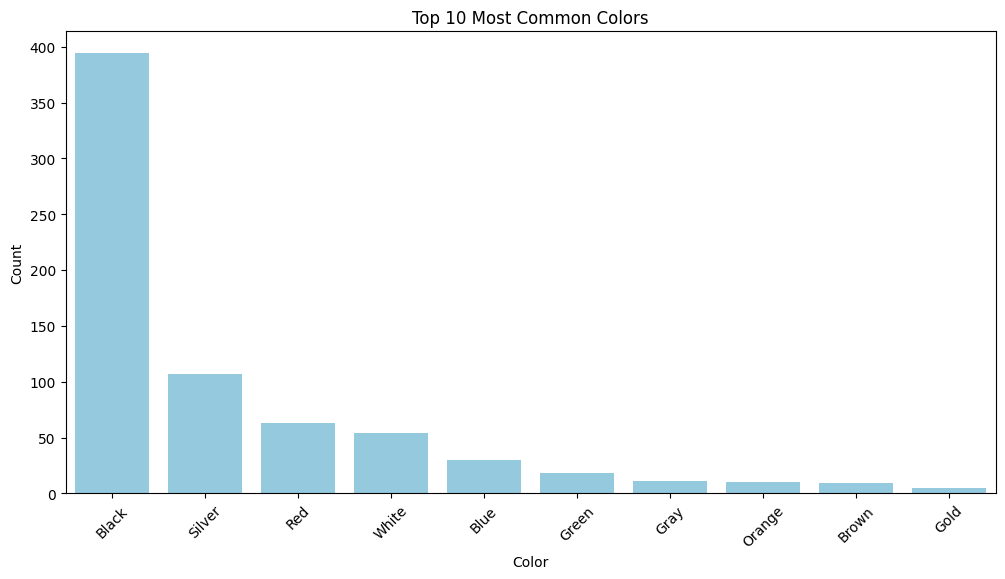

In [17]:
# ----- EDA -----

# Common colors
all_colors = [color for sublist in colors_split for color in sublist]
color_counts = pd.Series(all_colors).value_counts()
top_colors = color_counts.head(10)

plt.figure(figsize=(12,6))
sns.barplot(x=top_colors.index, y=top_colors.values, color='skyblue')
plt.title('Top 10 Most Common Colors')
plt.xlabel('Color')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

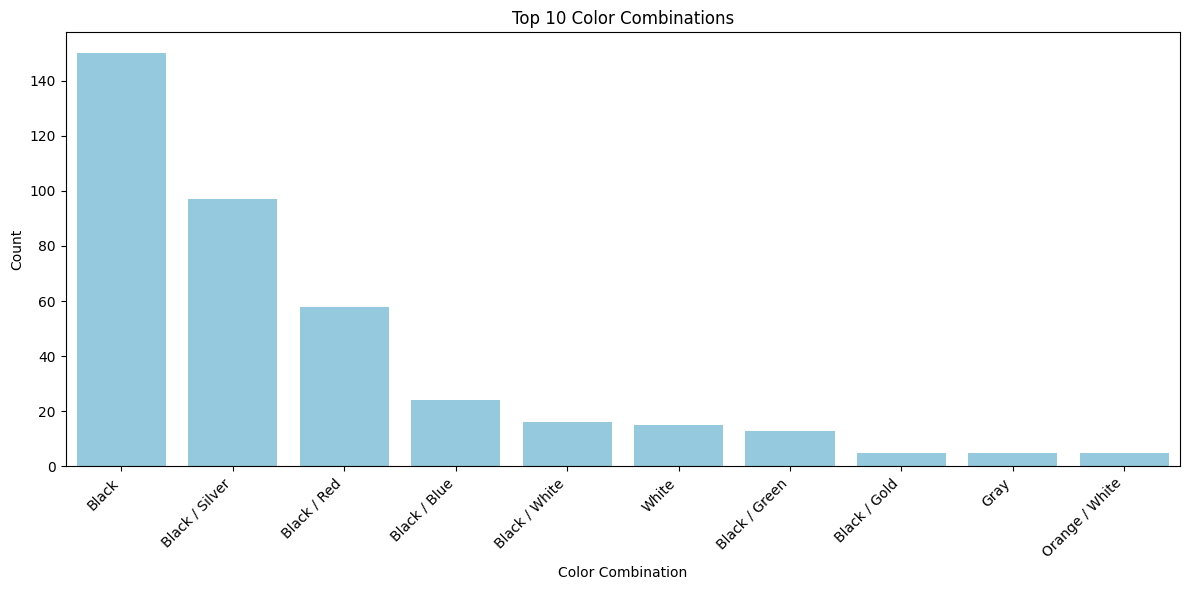

In [18]:
#Common color combos
color_combo_counts = headsets_no_outliers['color'].value_counts()
top_color_combos = color_combo_counts.head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_color_combos.index, y=top_color_combos.values, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title("Top 10 Color Combinations")
plt.xlabel("Color Combination")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

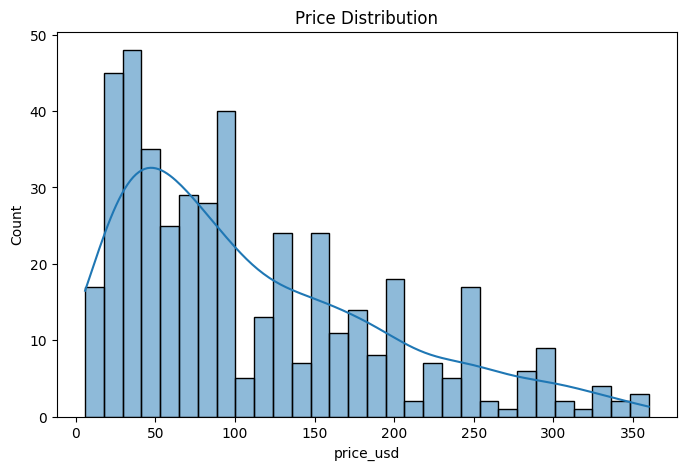

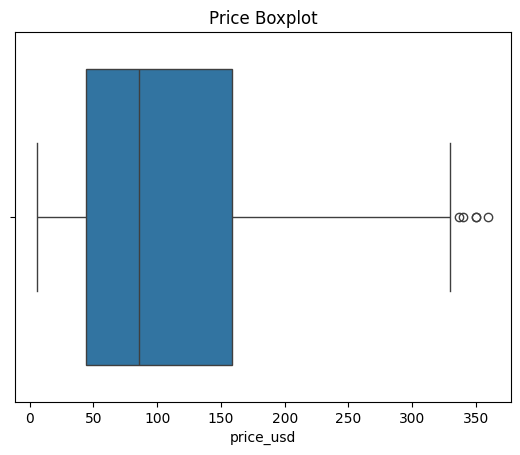

In [19]:
# Price Distribution
plt.figure(figsize=(8,5))
sns.histplot(headsets_no_outliers['price_usd'], bins=30, kde=True)
plt.title('Price Distribution')
plt.show()

sns.boxplot(x=headsets_no_outliers['price_usd'])
plt.title('Price Boxplot')
plt.show()

In [20]:
price_skewness = skew(headsets_no_outliers['price_usd'])
print(f'Skewness: {price_skewness:.3f}')

Skewness: 0.942


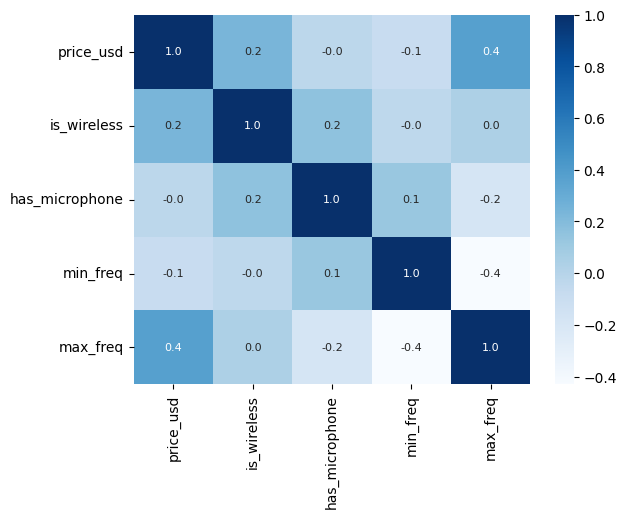

In [21]:
# Correlation heatmap
columns_to_keep = ['price_usd', 'is_wireless', 'has_microphone', 'min_freq', 'max_freq']
corr_data = headsets_no_outliers[columns_to_keep]
corr_heatmap = sns.heatmap(corr_data.corr(), annot=True, fmt=".1f", cmap="Blues", annot_kws={"size": 8})

## Modeling

### Random Forest Regressor
Predicting actual price

In [22]:
# ----- MODEL -----

columns_to_include = ['brand_encoded', 'min_freq', 'max_freq', 'is_wireless', 'form_factor']
y = headsets_no_outliers['price_usd']
X = headsets_no_outliers[columns_to_include]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5

mae = mean_absolute_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.2f}")
print(f"Mean Absolute Error: {mae: .2f} ")
print("R²:", r2)

Test RMSE: 60.51
Mean Absolute Error:  45.98 
R²: 0.4982630830673841


### Random Forest Classifier
Defining and predicting price categories

In [23]:
# ----- Feature Engineering for Price Categories -----

def price_category(price):
    if price <= Q1:
        return 'Affordable'
    elif price <= Q3:
        return 'Mid-Range'
    else:
        return 'Expensive'

headsets_no_outliers['price_cat'] = headsets_no_outliers['price_usd'].apply(price_category)
print(headsets_no_outliers['price_cat'].unique())

price_cat_mapping = {'Affordable': 0, 'Mid-Range': 1, 'Expensive': 2}
headsets_no_outliers['price_cat'] = headsets_no_outliers['price_cat'].map(price_cat_mapping)
print(headsets_no_outliers['price_cat'].unique())


['Mid-Range' 'Expensive' 'Affordable']
[1 2 0]


In [25]:
headsets_no_outliers.to_csv("model_data.csv", index=False)

In [24]:
# ----- Random Forest Classification Model w/ Price Categories

#columns_to_include = ['brand_encoded', 'min_freq', 'max_freq', 'is_wireless', 'form_factor']
columns_to_drop = ['price_cat', 'price_usd', 'brand', 'model', 'brand_grouped', 'color']
X = headsets_no_outliers.drop(columns=columns_to_drop)
print(X.columns)
y = headsets_no_outliers['price_cat']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_cat_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_cat_model.fit(X_train, y_train)
y_pred = rf_cat_model.predict(X_test)

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Index(['form_factor', 'has_microphone', 'is_wireless', 'type', 'min_freq',
       'max_freq', 'color_yellow', 'color_gray', 'color_orange',
       'color_purple', 'color_beige', 'color_blue', 'color_pink', 'color_gold',
       'color_amber', 'color_green', 'color_silver', 'color_gunmetal',
       'color_black', 'color_red', 'color_white', 'color_brown', 'color_camo',
       'color_copper', 'color_multicolor', 'brand_encoded'],
      dtype='object')

Accuracy: 0.5164835164835165

Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.48      0.54        23
           1       0.52      0.63      0.57        46
           2       0.41      0.32      0.36        22

    accuracy                           0.52        91
   macro avg       0.51      0.48      0.49        91
weighted avg       0.52      0.52      0.51        91

